# Preprocessing Washington Allocation data for WaDE upload.
- Purpose:  To preprocess the Washington data into one master file for simple DataFrame creation and extraction

Useful Links to Data:
- The Data - Geographic Water Information System (GWIS)Data from the WA stat: https://fortress.wa.gov/ecy/gispublic/DataDownload/wr/GWIS_Data/
- Data dictionary - https://fortress.wa.gov/ecy/gispublic/DataDownload/wr/GWIS_Data/GWIS_Data_Dictionary/
- Public website   - https://ecology.wa.gov/Water-Shorelines/Water-supply/Water-rights

In [1]:
import os
import sys
print(os.environ['CONDA_DEFAULT_ENV'])
print(sys.version)

wade_data_project
3.13.5 | packaged by conda-forge | (main, Jun 16 2025, 08:20:19) [MSC v.1943 64 bit (AMD64)]


In [2]:
#Needed Libraries

# working with data
import numpy as np
import pandas as pd
import geopandas as gpd

# visulizaiton
import matplotlib.pyplot as plt
import seaborn as sns

# API retrieval
import requests
import json

# Cleanup
import re
from datetime import datetime
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook
pd.set_option('display.float_format', lambda x: '%.5f' % x) # suppress scientific notation in Pandas

In [3]:
# Working Directory
workingDir = "G:/Shared drives/WaDE Data/WaDE Data Folder/Washington/WaterAllocation/RawInputData"
os.chdir(workingDir)

## POD Data

In [4]:
# Input File, contains PoD info
d_pointFile = "shapefiles/D_Point.zip"
#df_1 = gpd.read_file(d_pointFile, encoding = "ISO-8859-1").replace(np.nan, "")
df_1 = gpd.read_file(d_pointFile)

# WaDE UUID tracker for data assessment
if 'WaDEUUID' not in df_1:
    df_1['WaDEUUID'] = "waD" + df_1.index.astype(str)
    df_1.to_csv('D_Point.zip', compression=dict(method='zip', archive_name='D_Point.csv'), index=False)

df_1['D_Point_ID'] = df_1['D_Point_ID'].astype(int)
print(len(df_1))
df_1.head()

164832


,D_Point_ID,D_Point_Ty,Location_C,Assoc_FL,Misc_CD,Position_W,Active_DT,Inactive_D,Update_TD,Update_Use,Comment_DS,Created_TD,Created_Us,Latitude,Longitude,geometry,WaDEUUID
0,200801,WL,U,N,None,S,NaT,NaT,2013-03-28,"""ECY\DKRO461""",None,NaT,None,46.58080,-120.39900,POINT (-120.39878 46.58081),waD0
1,200889,MW,G,Y,None,S,NaT,NaT,2020-08-18,KWIN461,AAS 902,NaT,None,46.58370,-119.79900,POINT (-119.79874 46.5837),waD1
2,200890,MW,G,Y,None,S,NaT,NaT,2020-08-18,KWIN461,AAS 906,NaT,None,46.58370,-119.81000,POINT (-119.81025 46.58374),waD2
3,201092,WL,U,Y,None,S,NaT,NaT,NaT,None,None,NaT,None,46.58720,-120.77400,POINT (-120.77422 46.58718),waD3
4,201191,WL,G,Y,None,S,NaT,NaT,2024-08-27,NMON461,None,NaT,None,46.43540,-120.20300,POINT (-120.20264 46.43544),waD4


In [5]:
# Input File, Bridge table
D_Point_WR_DocFile = "D_Point_WR_Doc.zip"
df_2 = pd.read_csv(D_Point_WR_DocFile).replace(np.nan, "")

df_2['D_Point_ID'] = df_2['D_Point_ID'].replace("", 0).fillna(0).astype(float).astype(int)
print(len(df_2))
df_2.head()

184900


C:\Users\rjame\AppData\Local\Temp\ipykernel_6972\4279013410.py:3: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2 = pd.read_csv(D_Point_WR_DocFile).replace(np.nan, "")
C:\Users\rjame\AppData\Local\Temp\ipykernel_6972\4279013410.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_2['D_Point_ID'] = df_2['D_Point_ID'].replace("", 0).fillna(0).astype(float).astype(int)


,D_Point_WR_Doc_ID,D_Point_ID,WR_Doc_NR,WR_Doc_ID,Active_DT,Inactive_DT,Update_TD,Update_User_ID,Created_TD,Created_User_ID
0,,272991,G4-26991C,,,,9/25/2023 10:36:58,AVOG461,,
1,,204905,G4-29018C,,,,,,,
2,,204906,G4-29018C,,,,,,,
3,,204907,G4-25116C,,,,,,,
4,,200095,G3-00235C,,,,,,,


In [6]:
# Input File, Contains water use and owner info
Person_Plus_EXTRACT_FromWRTSnotGWISFile = "Person_Plus_EXTRACT_FromWRTSnotGWIS.zip"
df_3 = pd.read_csv(Person_Plus_EXTRACT_FromWRTSnotGWISFile).replace(np.nan, "")
print(len(df_3))
df_3.head()

309120


,OBJECTID_1,WaRecId,WaRecId_1,WR_Doc_ID,WaRecPhaseId,PartyRoleTypeCode,PersonLastOrOrganizationNM,PersonFirstNM,PersonMINM,PersonAddressLine1AD,PersonAddressLine2AD,PersonAddressLine3AD,PersonAddressCityAD,PersonAddressStateCode,PersonAddressZipCodeAD,WaRecRCWClassTypeCode,EcologyRegionCode,WaRecPrimaryNumber,PriorityDate,WaRecProcessStatusTypeCode,WaRecClaimTypeCode,WaRecPhaseTypeCode,WaRecPhaseStageTypeCode,InstantaneousQuantity,AnnualVolumeQuantity,IrrigatedAreaQuantity,InstantaneousUnitCode,PurposeOfUseTypeCodes
0,177316,2142777,2142777,2142777,-1,Primary,Creston Town,,,,,,,,,groundwater,ERO,G3-*00582S,9/1/1942 0:00:00,Inactive,,,,,,,,
1,265169,4676649,4676649,4676649,-1,Primary,Etheridge,Ronnie,R,PO Box 163,,,Manson,WA,98831-0163,groundwater,ERO,G3-QB0498(B),2/20/1975 0:00:00,Active,,,,,,,,
2,254813,4274886,4274886,4274886,-1,Attorney,Hart & Winfree,,,910 Franklin Ave Ste 1,PO Box 210,,Sunnyside,WA,98944,groundwater,CRO,CG4-27035@1,6/8/2006 0:00:00,Active,,,,,,,,
3,265170,4676649,4676649,4676649,-1,Co-Primary,Etheridge,Wanda,M,PO Box 163,,,Manson,WA,98831-0163,groundwater,ERO,G3-QB0498(B),2/20/1975 0:00:00,Active,,,,,,,,
4,282324,6553789,6553789,6553789,-1,Primary,Farmland Reserve Inc,,,6716 W Rio Grande Ave,PO Box 2308,,Pasco,WA,99302-2308,surfaceWater,CRO,CS4-16571(J)@1,2/19/2015 0:00:00,Active,,,,,,,,


In [7]:
# Merging dataframes into one, using left-join.
dfinPOD = pd.DataFrame()
dfinPOD = pd.merge(df_1, df_2, left_on='D_Point_ID', right_on='D_Point_ID', how='left') # Joinning PoD data
dfinPOD = pd.merge(dfinPOD, df_3, left_on=dfinPOD.WR_Doc_ID.replace("", 0).fillna(0).astype(int).astype(str).str.strip(), right_on=df_3.WR_Doc_ID.replace("", 0).fillna(0).astype(int).astype(str).str.strip(), how='left') # Joinning PoD data

dfinPOD = dfinPOD.drop_duplicates().replace(np.nan, "").replace("nan,nan", "").reset_index(drop=True)
print(len(dfinPOD))
dfinPOD.head(1)

C:\Users\rjame\AppData\Local\Temp\ipykernel_6972\2112763265.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfinPOD = pd.merge(dfinPOD, df_3, left_on=dfinPOD.WR_Doc_ID.replace("", 0).fillna(0).astype(int).astype(str).str.strip(), right_on=df_3.WR_Doc_ID.replace("", 0).fillna(0).astype(int).astype(str).str.strip(), how='left') # Joinning PoD data


220205


,key_0,D_Point_ID,D_Point_Ty,Location_C,Assoc_FL,Misc_CD,Position_W,Active_DT_x,Inactive_D,Update_TD_x,Update_Use,Comment_DS,Created_TD_x,Created_Us,Latitude,Longitude,geometry,WaDEUUID,D_Point_WR_Doc_ID,WR_Doc_NR,WR_Doc_ID_x,Active_DT_y,Inactive_DT,Update_TD_y,Update_User_ID,Created_TD_y,Created_User_ID,OBJECTID_1,WaRecId,WaRecId_1,WR_Doc_ID_y,WaRecPhaseId,PartyRoleTypeCode,PersonLastOrOrganizationNM,PersonFirstNM,PersonMINM,PersonAddressLine1AD,PersonAddressLine2AD,PersonAddressLine3AD,PersonAddressCityAD,PersonAddressStateCode,PersonAddressZipCodeAD,WaRecRCWClassTypeCode,EcologyRegionCode,WaRecPrimaryNumber,PriorityDate,WaRecProcessStatusTypeCode,WaRecClaimTypeCode,WaRecPhaseTypeCode,WaRecPhaseStageTypeCode,InstantaneousQuantity,AnnualVolumeQuantity,IrrigatedAreaQuantity,InstantaneousUnitCode,PurposeOfUseTypeCodes
0,0,200801,WL,U,N,,S,NaT,NaT,2013-03-28,"""ECY\DKRO461""",,NaT,,46.58080,-120.39900,POINT (-120.39878 46.58081),waD0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [8]:
# fix owner name

def assignOwner(valueFirst, valueMid, valueLast):
    #--- First Name ---
    if valueFirst == "" or pd.isnull(valueFirst):
        FirstName = ""
    else:
        FirstName = str(valueFirst).strip()
        
    #--- Midile Initial ---
    if valueMid == "" or pd.isnull(valueMid):
        MidName = ""
    else:
        MidName = str(valueMid).strip()
    
    #--- Last Name ---
    if valueLast == "" or pd.isnull(valueLast):
        LastName = ""
    else:
        LastName = str(valueLast).strip()

    if LastName == "":
        outlist = LastName + FirstName + MidName
    else:
        outlist = LastName + ", " + FirstName + " "+ MidName
        
    outlist = re.sub("[$@&.;,/\)(-]", "", outlist).title().replace("  ", " ").strip()
    
    return outlist


dfinPOD['Owner'] = dfinPOD.apply(lambda row: assignOwner(row['PersonFirstNM'],
                                               row['PersonMINM'],
                                               row['PersonLastOrOrganizationNM']), axis=1)
dfinPOD['Owner'].unique()

<>:27: SyntaxWarning: invalid escape sequence '\)'
<>:27: SyntaxWarning: invalid escape sequence '\)'
C:\Users\rjame\AppData\Local\Temp\ipykernel_6972\2231572027.py:27: SyntaxWarning: invalid escape sequence '\)'
  outlist = re.sub("[$@&.;,/\)(-]", "", outlist).title().replace("  ", " ").strip()


array(['', 'Ste Michelle Wine Estates Ltd Paterson', 'Mackie Sandy', ...,
       'Us Bureau Reclamation Coulee Dam', 'Ramey P', 'Holl Hubert J'],
      shape=(88739,), dtype=object)

In [9]:
# For creating AllocationAmount
def assignAllocationAmount(colrowValueIQ, colrowValueUC):
    if colrowValueIQ == '' or pd.isnull(colrowValueIQ):
        outVal = ""
    elif colrowValueIQ <= 0 or pd.isnull(colrowValueIQ):
        outVal = 0
    else:
        MultiFactor = 1.0
        gpmcfsUnit = colrowValueUC.strip()
        if gpmcfsUnit == 'GPM':
            MultiFactor = 0.00222800926
        elif gpmcfsUnit == 'GPD':
            MultiFactor = 1.0 / 646317.0
        try:
            outVal = MultiFactor * colrowValueIQ
        except:
            outVal = colrowValueIQ
    return outVal

dfinPOD['in_AllocationFlow_CFS'] = dfinPOD.apply(lambda row: assignAllocationAmount(row['InstantaneousQuantity'], row['InstantaneousUnitCode']), axis=1)
dfinPOD['in_AllocationFlow_CFS'].unique()

array(['', 4.45601852, 4.0104166679999995, ..., 2.88750000096,
       0.17556712968799995, 75000.0], shape=(2718,), dtype=object)

In [10]:
# remove Sites where ASSOC_FL != 'Y'
# remove Polygons where WR_Doc_ID_x == ""
dfinPOD = dfinPOD[dfinPOD['Assoc_FL'] == 'Y'].reset_index(drop=True)
dfinPOD = dfinPOD[dfinPOD['WR_Doc_ID_x'] != ""].reset_index(drop=True)
print(len(dfinPOD))
dfinPOD.head(1)

160358


,key_0,D_Point_ID,D_Point_Ty,Location_C,Assoc_FL,Misc_CD,Position_W,Active_DT_x,Inactive_D,Update_TD_x,Update_Use,Comment_DS,Created_TD_x,Created_Us,Latitude,Longitude,geometry,WaDEUUID,D_Point_WR_Doc_ID,WR_Doc_NR,WR_Doc_ID_x,Active_DT_y,Inactive_DT,Update_TD_y,Update_User_ID,Created_TD_y,Created_User_ID,OBJECTID_1,WaRecId,WaRecId_1,WR_Doc_ID_y,WaRecPhaseId,PartyRoleTypeCode,PersonLastOrOrganizationNM,PersonFirstNM,PersonMINM,PersonAddressLine1AD,PersonAddressLine2AD,PersonAddressLine3AD,PersonAddressCityAD,PersonAddressStateCode,PersonAddressZipCodeAD,WaRecRCWClassTypeCode,EcologyRegionCode,WaRecPrimaryNumber,PriorityDate,WaRecProcessStatusTypeCode,WaRecClaimTypeCode,WaRecPhaseTypeCode,WaRecPhaseStageTypeCode,InstantaneousQuantity,AnnualVolumeQuantity,IrrigatedAreaQuantity,InstantaneousUnitCode,PurposeOfUseTypeCodes,Owner,in_AllocationFlow_CFS
0,4271345,200890,MW,G,Y,,S,NaT,NaT,2020-08-18,KWIN461,AAS 906,NaT,,46.58370,-119.81000,POINT (-119.81025 46.58374),waD2,,CG4-GWC5494-A,4271345.00000,,,12/20/2018 13:47:05,HRID461,12/20/2018 13:47:05,HRID461,274369.00000,4271345.00000,4271345.00000,4271345.00000,129957.00000,Primary,Ste Michelle Wine Estates Ltd (Paterson),,,PO Box 231,,,Paterson,WA,99345-0231,groundwater,CRO,CG4-GWC5494-A,4/27/2006 0:00:00,Inactive,,ChangeROE,Superseded,2000.00000,420.90000,345.00000,GPM,IR,Ste Michelle Wine Estates Ltd Paterson,4.45602


In [11]:
# create output POD dataframe
outPOD = pd.DataFrame()

# Data Assessment UUID
outPOD['WaDEUUID'] = dfinPOD['WaDEUUID']

# Method Info
outPOD['in_MethodUUID'] = "WAwr_M1"

# Variable Info
outPOD['in_VariableSpecificUUID'] = "WAwr_V1"

# Organization Info
outPOD['in_OrganizationUUID'] = "WAwr_O1"

# WaterSource Info
outPOD['in_Geometry'] = ""
outPOD['in_GNISFeatureNameCV'] = ""
outPOD['in_WaterQualityIndicatorCV'] = ""
outPOD['in_WaterSourceName'] = ""
outPOD['in_WaterSourceNativeID'] = ""
outPOD['in_WaterSourceTypeCV'] = dfinPOD['WaRecRCWClassTypeCode'].str.title().str.strip()

# Site Info
outPOD['in_CoordinateAccuracy'] = dfinPOD['Location_C']
outPOD['in_CoordinateMethodCV'] = ""
outPOD['in_County'] = ""
outPOD['in_EPSGCodeCV'] = 4326
outPOD['in_Geometry'] = ""
outPOD['in_GNISCodeCV'] = ""
outPOD['in_HUC12'] = ""
outPOD['in_HUC8'] = ""
outPOD['in_Latitude'] = dfinPOD['Latitude']
outPOD['in_Longitude'] = dfinPOD['Longitude']
outPOD['in_NHDNetworkStatusCV'] = ""
outPOD['in_NHDProductCV'] = ""
outPOD['in_PODorPOUSite'] = "POD"
outPOD['in_SiteName'] = ""
outPOD['in_SiteNativeID'] = "POD" + dfinPOD['D_Point_ID'].replace("", 0).fillna(0).astype(float).astype(int).astype(str)
outPOD['in_SitePoint'] = ""
outPOD['in_SiteTypeCV'] = dfinPOD['D_Point_Ty']
outPOD['in_StateCV'] = "WA"
outPOD['in_USGSSiteID'] = ""

# AllocationAmount Info
outPOD['in_AllocationApplicationDate'] = ""
outPOD['in_AllocationAssociatedConsumptiveUseSiteIDs'] = ""
outPOD['in_AllocationAssociatedWithdrawalSiteIDs'] = ""
outPOD['in_AllocationBasisCV'] = ""
outPOD['in_AllocationChangeApplicationIndicator'] = ""
outPOD['in_AllocationCommunityWaterSupplySystem'] = ""
outPOD['in_AllocationCropDutyAmount'] = ""
outPOD['in_AllocationExpirationDate'] = ""
outPOD['in_AllocationFlow_CFS'] = dfinPOD['in_AllocationFlow_CFS']
outPOD['in_AllocationLegalStatusCV'] = dfinPOD['WaRecProcessStatusTypeCode']
outPOD['in_AllocationNativeID'] =  "wa" + dfinPOD['WR_Doc_ID_x'].replace("", 0).fillna(0).astype(int).astype(str)
outPOD['in_AllocationOwner'] = dfinPOD['Owner']
outPOD['in_AllocationPriorityDate'] = dfinPOD['PriorityDate']
outPOD['in_AllocationSDWISIdentifierCV'] = ""
outPOD['in_AllocationTimeframeEnd'] = ""
outPOD['in_AllocationTimeframeStart'] = ""
outPOD['in_AllocationTypeCV'] = dfinPOD['WaRecPhaseTypeCode']
outPOD['in_AllocationVolume_AF'] = dfinPOD['AnnualVolumeQuantity']
outPOD['in_BeneficialUseCategory'] = dfinPOD['PurposeOfUseTypeCodes'].astype(str)
outPOD['in_CommunityWaterSupplySystem'] = ""
outPOD['in_CropTypeCV'] = ""
outPOD['in_CustomerTypeCV'] = ""
outPOD['in_DataPublicationDate'] = ""
outPOD['in_DataPublicationDOI'] = ""
outPOD['in_ExemptOfVolumeFlowPriority'] = 0
outPOD['in_GeneratedPowerCapacityMW'] = ""
outPOD['in_IrrigatedAcreage'] = dfinPOD['IrrigatedAreaQuantity']
outPOD['in_IrrigationMethodCV'] = ""
outPOD['in_LegacyAllocationIDs'] = ""
outPOD['in_OwnerClassificationCV'] = ""
outPOD['in_PopulationServed'] = ""
outPOD['in_PowerType'] = ""
outPOD['in_PrimaryBeneficialUseCategory'] = ""
outPOD['in_SDWISIdentifierCV'] = ""
outPOD['in_WaterAllocationNativeURL'] = "https://appswr.ecology.wa.gov/waterrighttrackingsystem/WaterRights/WaterRightRecord.aspx?waRecId=" + dfinPOD['WaRecId'].replace("", 0).fillna(0).astype(int).astype(str)

outPOD = outPOD.drop_duplicates().reset_index(drop=True)
print(len(outPOD))
outPOD.head()

C:\Users\rjame\AppData\Local\Temp\ipykernel_6972\2672650412.py:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  outPOD['in_AllocationNativeID'] =  "wa" + dfinPOD['WR_Doc_ID_x'].replace("", 0).fillna(0).astype(int).astype(str)
C:\Users\rjame\AppData\Local\Temp\ipykernel_6972\2672650412.py:80: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  outPOD['in_WaterAllocationNativeURL'] = "https://appswr.ecology.wa.gov/waterrighttrackingsystem/WaterRights/WaterRightRecord.aspx?waRecId=" + dfinPOD['WaRecId'].replace("", 0).fillna(0).astype(int).astype(str

159130


,WaDEUUID,in_MethodUUID,in_VariableSpecificUUID,in_OrganizationUUID,in_Geometry,in_GNISFeatureNameCV,in_WaterQualityIndicatorCV,in_WaterSourceName,in_WaterSourceNativeID,in_WaterSourceTypeCV,in_CoordinateAccuracy,in_CoordinateMethodCV,in_County,in_EPSGCodeCV,in_GNISCodeCV,in_HUC12,in_HUC8,in_Latitude,in_Longitude,in_NHDNetworkStatusCV,in_NHDProductCV,in_PODorPOUSite,in_SiteName,in_SiteNativeID,in_SitePoint,in_SiteTypeCV,in_StateCV,in_USGSSiteID,in_AllocationApplicationDate,in_AllocationAssociatedConsumptiveUseSiteIDs,in_AllocationAssociatedWithdrawalSiteIDs,in_AllocationBasisCV,in_AllocationChangeApplicationIndicator,in_AllocationCommunityWaterSupplySystem,in_AllocationCropDutyAmount,in_AllocationExpirationDate,in_AllocationFlow_CFS,in_AllocationLegalStatusCV,in_AllocationNativeID,in_AllocationOwner,in_AllocationPriorityDate,in_AllocationSDWISIdentifierCV,in_AllocationTimeframeEnd,in_AllocationTimeframeStart,in_AllocationTypeCV,in_AllocationVolume_AF,in_BeneficialUseCategory,in_CommunityWaterSupplySystem,in_CropTypeCV,in_CustomerTypeCV,in_DataPublicationDate,in_DataPublicationDOI,in_ExemptOfVolumeFlowPriority,in_GeneratedPowerCapacityMW,in_IrrigatedAcreage,in_IrrigationMethodCV,in_LegacyAllocationIDs,in_OwnerClassificationCV,in_PopulationServed,in_PowerType,in_PrimaryBeneficialUseCategory,in_SDWISIdentifierCV,in_WaterAllocationNativeURL
0,waD2,WAwr_M1,WAwr_V1,WAwr_O1,,,,,,Groundwater,G,,,4326,,,,46.58370,-119.81000,,,POD,,POD200890,,MW,WA,,,,,,,,,,4.45602,Inactive,wa4271345,Ste Michelle Wine Estates Ltd Paterson,4/27/2006 0:00:00,,,,ChangeROE,420.90000,IR,,,,,,0,,345.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...
1,waD2,WAwr_M1,WAwr_V1,WAwr_O1,,,,,,Groundwater,G,,,4326,,,,46.58370,-119.81000,,,POD,,POD200890,,MW,WA,,,,,,,,,,4.45602,Inactive,wa4271345,Mackie Sandy,4/27/2006 0:00:00,,,,ChangeROE,420.90000,IR,,,,,,0,,345.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...
2,waD2,WAwr_M1,WAwr_V1,WAwr_O1,,,,,,Groundwater,G,,,4326,,,,46.58370,-119.81000,,,POD,,POD200890,,MW,WA,,,,,,,,,,4.45602,Inactive,wa4271345,Means Mike,4/27/2006 0:00:00,,,,ChangeROE,420.90000,IR,,,,,,0,,345.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...
3,waD4,WAwr_M1,WAwr_V1,WAwr_O1,,,,,,Groundwater,G,,,4326,,,,46.43540,-120.20300,,,POD,,POD201191,,WL,WA,,,,,,,,,,4.01042,Active,wa6463294,Fagerness Kari,2/6/2015 0:00:00,,,,ChangeROE,873.00000,IR,,,,,,0,,429.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...
4,waD4,WAwr_M1,WAwr_V1,WAwr_O1,,,,,,Groundwater,G,,,4326,,,,46.43540,-120.20300,,,POD,,POD201191,,WL,WA,,,,,,,,,,4.01042,Active,wa6463294,Wa Dnr *,2/6/2015 0:00:00,,,,ChangeROE,873.00000,IR,,,,,,0,,429.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...


## POU Data

In [12]:
# Input File - PoU Shapefile Data
# export dataframe as zipped csv
pouInput = 'shapefiles/WR_Doc_POU1.zip'
df_1u = gpd.read_file(pouInput)
df_1u['geometry'] = df_1u['geometry'].to_crs(epsg=4326) # Realign Geometry Projection

# WaDE UUID tracker for data assessment
if 'WaDEUUID' not in df_1u:
    df_1u['WaDEUUID'] = "waU" + df_1u.index.astype(str)
    df_1u.to_csv('WR_Doc_POU1.zip', compression=dict(method='zip', archive_name='WR_Doc_POU1.csv'), index=False)

df_1u = df_1u.drop_duplicates().reset_index(drop=True)
print(len(df_1u))
df_1u.head(1)

C:\Users\rjame\anaconda3\envs\wade_data_project\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: /vsizip/shapefiles/WR_Doc_POU1.zip/WR_Doc_POU1.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


163575


,WR_DOC_ID,WR_Doc_POU,Fill_CD,WR_Doc_NR,WR_Doc_Typ,Quality_CD,Misc_CD,Position_W,Active_DT,Inactive_D,Update_TD,Update_Use,Comment_DS,Created_TD,Created_Us,cent_Latit,cent_Longi,Shape_Leng,Shape_Area,geometry,WaDEUUID
0,2084118,0,7,GWC01066-D,CE,G,RECHECKED\WWT,S,NaT,NaT,2009-01-23,"""ECY\DKRO461""",None,NaT,None,46.59121,-119.73537,0.10082,0.00039,"POLYGON ((-119.74933 46.58447, -119.74899 46.5...",waU0


In [13]:
# Create WaDE Specific SiteNativeID
# temp fix for lack of site id value

df_1u['in_SiteNativeID'] = "wadeID" + df_1u.index.astype(str)
df_1u.head()

,WR_DOC_ID,WR_Doc_POU,Fill_CD,WR_Doc_NR,WR_Doc_Typ,Quality_CD,Misc_CD,Position_W,Active_DT,Inactive_D,Update_TD,Update_Use,Comment_DS,Created_TD,Created_Us,cent_Latit,cent_Longi,Shape_Leng,Shape_Area,geometry,WaDEUUID,in_SiteNativeID
0,2084118,0,7,GWC01066-D,CE,G,RECHECKED\WWT,S,NaT,NaT,2009-01-23,"""ECY\DKRO461""",None,NaT,None,46.59121,-119.73537,0.10082,0.00039,"POLYGON ((-119.74933 46.58447, -119.74899 46.5...",waU0,wadeID0
1,2084120,0,14,GWC01067-D,CE,G,None,S,NaT,NaT,2011-05-27,"""ECY\ATRO461""",None,NaT,None,46.58282,-119.76184,0.07164,0.00021,"POLYGON ((-119.74933 46.58447, -119.74966 46.5...",waU1,wadeID1
2,2084124,0,39,GWC01070-D,CE,G,None,S,NaT,NaT,2011-05-27,"""ECY\ATRO461""",None,NaT,None,46.58628,-119.77845,0.01769,0.00002,"POLYGON ((-119.7758 46.58451, -119.78105 46.58...",waU2,wadeID2
3,2084121,0,4,GWC01068-D,CE,G,None,S,NaT,NaT,2011-05-27,"""ECY\ATRO461""",None,NaT,None,46.58077,-119.78103,0.05656,0.00015,"POLYGON ((-119.7758 46.58451, -119.77053 46.58...",waU3,wadeID3
4,2084122,0,47,GWC01069-D,CE,G,None,S,NaT,NaT,2011-05-27,"""ECY\ATRO461""",None,NaT,None,46.57352,-119.76516,0.03528,0.00008,"POLYGON ((-119.77068 46.57707, -119.76004 46.5...",waU4,wadeID4


In [14]:
# Merging dataframes into one, using left-join.
# df_u1 and df3
dfinPOU = pd.DataFrame()
dfinPOU = pd.merge(df_1u, df_3, left_on=df_1u.WR_DOC_ID.replace("", 0).fillna(0).astype(float).astype(int).astype(str), 
                   right_on=df_3.WR_Doc_ID.replace("", 0).fillna(0).astype(float).astype(int).astype(str), how='left')

dfinPOU = dfinPOU.drop_duplicates().reset_index(drop=True)
print(len(dfinPOU))
dfinPOU.head(1)

186643


,key_0,WR_DOC_ID,WR_Doc_POU,Fill_CD,WR_Doc_NR,WR_Doc_Typ,Quality_CD,Misc_CD,Position_W,Active_DT,Inactive_D,Update_TD,Update_Use,Comment_DS,Created_TD,Created_Us,cent_Latit,cent_Longi,Shape_Leng,Shape_Area,geometry,WaDEUUID,in_SiteNativeID,OBJECTID_1,WaRecId,WaRecId_1,WR_Doc_ID,WaRecPhaseId,PartyRoleTypeCode,PersonLastOrOrganizationNM,PersonFirstNM,PersonMINM,PersonAddressLine1AD,PersonAddressLine2AD,PersonAddressLine3AD,PersonAddressCityAD,PersonAddressStateCode,PersonAddressZipCodeAD,WaRecRCWClassTypeCode,EcologyRegionCode,WaRecPrimaryNumber,PriorityDate,WaRecProcessStatusTypeCode,WaRecClaimTypeCode,WaRecPhaseTypeCode,WaRecPhaseStageTypeCode,InstantaneousQuantity,AnnualVolumeQuantity,IrrigatedAreaQuantity,InstantaneousUnitCode,PurposeOfUseTypeCodes
0,2084118,2084118,0,7,GWC01066-D,CE,G,RECHECKED\WWT,S,NaT,NaT,2009-01-23,"""ECY\DKRO461""",None,NaT,None,46.59121,-119.73537,0.10082,0.00039,"POLYGON ((-119.74933 46.58447, -119.74899 46.5...",waU0,wadeID0,84235.00000,2084118.00000,2084118.00000,2084118.00000,59585.00000,Primary,USARMY Corps Engineers,,,,,,,,,groundwater,CRO,G4-*01105SWRIS,4/1/1927 0:00:00,Active,,Certificate,,1375.00000,800.00000,200.00000,GPM,DG IR


In [15]:
def assignOwner(valueFirst, valueMid, valueLast):
    #--- First Name ---
    if valueFirst == "" or pd.isnull(valueFirst):
        FirstName = ""
    else:
        FirstName = str(valueFirst).strip()
        
    #--- Midile Initial ---
    if valueMid == "" or pd.isnull(valueMid):
        MidName = ""
    else:
        MidName = str(valueMid).strip()
    
    #--- Last Name ---
    if valueLast == "" or pd.isnull(valueLast):
        LastName = ""
    else:
        LastName = str(valueLast).strip()

    if LastName == "":
        outlist = LastName + FirstName + MidName
    else:
        outlist = LastName + ", " + FirstName + " "+ MidName
        
    outlist = re.sub("[$@&.;,/\)(-]", "", outlist).title().replace("  ", " ").strip()
    
    return outlist


dfinPOU['Owner'] = dfinPOU.apply(lambda row: assignOwner(row['PersonFirstNM'], row['PersonMINM'], row['PersonLastOrOrganizationNM']), axis=1)
dfinPOU['Owner'].unique()

<>:25: SyntaxWarning: invalid escape sequence '\)'
<>:25: SyntaxWarning: invalid escape sequence '\)'
C:\Users\rjame\AppData\Local\Temp\ipykernel_6972\1911280054.py:25: SyntaxWarning: invalid escape sequence '\)'
  outlist = re.sub("[$@&.;,/\)(-]", "", outlist).title().replace("  ", " ").strip()


array(['Usarmy Corps Engineers', 'S Martinez Livestock Inc',
       'Trainor Russell C', ..., 'Roberts Wilburn',
       'Gerde Robert J Et Ux', 'Haden Glen'],
      shape=(115878,), dtype=object)

In [16]:
# For creating AllocationAmount
def assignAllocationAmount(colrowValueIQ, colrowValueUC):
    if colrowValueIQ == '' or pd.isnull(colrowValueIQ):
        outVal = ""
    elif colrowValueIQ <= 0 or pd.isnull(colrowValueIQ):
        outVal = 0
    else:
        MultiFactor = 1.0
        gpmcfsUnit = colrowValueUC.strip()
        if gpmcfsUnit == 'GPM':
            MultiFactor = 0.00222800926
        elif gpmcfsUnit == 'GPD':
            MultiFactor = 1.0 / 646317.0
        try:
            outVal = MultiFactor * colrowValueIQ
        except:
            outVal = colrowValueIQ
    return outVal

dfinPOU['in_AllocationFlow_CFS'] =  dfinPOU.apply(lambda row: assignAllocationAmount(row['InstantaneousQuantity'], row['InstantaneousUnitCode']), axis=1)
dfinPOU['in_AllocationFlow_CFS'].unique()

array([3.0635127324999996, 3.787615742, 0.33420138899999996, ...,
       2.88750000096, 0.17556712968799995, 0.2224],
      shape=(3568,), dtype=object)

In [17]:
# remove Polygons where WR_Doc_NR != '' (meaning their id field is blank)
# remove Polygons where WR_DOC_ID == 99999 (99999 is their 'blank' value field)
dfinPOU = dfinPOU[dfinPOU['WR_Doc_NR'] != ""].reset_index(drop=True)
dfinPOU = dfinPOU[dfinPOU['WR_DOC_ID'] != 99999].reset_index(drop=True)
print(len(dfinPOU))
dfinPOU.head(1)

186624


,key_0,WR_DOC_ID,WR_Doc_POU,Fill_CD,WR_Doc_NR,WR_Doc_Typ,Quality_CD,Misc_CD,Position_W,Active_DT,Inactive_D,Update_TD,Update_Use,Comment_DS,Created_TD,Created_Us,cent_Latit,cent_Longi,Shape_Leng,Shape_Area,geometry,WaDEUUID,in_SiteNativeID,OBJECTID_1,WaRecId,WaRecId_1,WR_Doc_ID,WaRecPhaseId,PartyRoleTypeCode,PersonLastOrOrganizationNM,PersonFirstNM,PersonMINM,PersonAddressLine1AD,PersonAddressLine2AD,PersonAddressLine3AD,PersonAddressCityAD,PersonAddressStateCode,PersonAddressZipCodeAD,WaRecRCWClassTypeCode,EcologyRegionCode,WaRecPrimaryNumber,PriorityDate,WaRecProcessStatusTypeCode,WaRecClaimTypeCode,WaRecPhaseTypeCode,WaRecPhaseStageTypeCode,InstantaneousQuantity,AnnualVolumeQuantity,IrrigatedAreaQuantity,InstantaneousUnitCode,PurposeOfUseTypeCodes,Owner,in_AllocationFlow_CFS
0,2084118,2084118,0,7,GWC01066-D,CE,G,RECHECKED\WWT,S,NaT,NaT,2009-01-23,"""ECY\DKRO461""",None,NaT,None,46.59121,-119.73537,0.10082,0.00039,"POLYGON ((-119.74933 46.58447, -119.74899 46.5...",waU0,wadeID0,84235.00000,2084118.00000,2084118.00000,2084118.00000,59585.00000,Primary,USARMY Corps Engineers,,,,,,,,,groundwater,CRO,G4-*01105SWRIS,4/1/1927 0:00:00,Active,,Certificate,,1375.00000,800.00000,200.00000,GPM,DG IR,Usarmy Corps Engineers,3.06351


In [18]:
# create output POD dataframe
outPOU = pd.DataFrame()

# Data Assessment UUID
outPOU['WaDEUUID'] = dfinPOU['WaDEUUID']

# Method Info
outPOU['in_MethodUUID'] = "WAwr_M1"

# Variable Info
outPOU['in_VariableSpecificUUID'] = "WAwr_V1"

# Organization Info
outPOU['in_OrganizationUUID'] = "WAwr_O1"

# WaterSource Info
outPOU['in_Geometry'] = ""
outPOU['in_GNISFeatureNameCV'] = ""
outPOU['in_WaterQualityIndicatorCV'] = ""
outPOU['in_WaterSourceName'] = ""
outPOU['in_WaterSourceNativeID'] = ""
outPOU['in_WaterSourceTypeCV'] = dfinPOU['WaRecRCWClassTypeCode'].str.title().str.strip()

# Site Info
outPOU['in_CoordinateAccuracy'] = ""
outPOU['in_CoordinateMethodCV'] = ""
outPOU['in_County'] = ""
outPOU['in_EPSGCodeCV'] = "4326"
outPOU['in_Geometry'] = dfinPOU['geometry']
outPOU['in_GNISCodeCV'] = ""
outPOU['in_HUC12'] = ""
outPOU['in_HUC8'] = ""
outPOU['in_Latitude'] = dfinPOU['cent_Latit']
outPOU['in_Longitude'] = dfinPOU['cent_Longi']
outPOU['in_NHDNetworkStatusCV'] = ""
outPOU['in_NHDProductCV'] = ""
outPOU['in_PODorPOUSite'] = "POU"
outPOU['in_SiteName'] = ""
outPOU['in_SiteNativeID'] = dfinPOU['in_SiteNativeID']
outPOU['in_SitePoint'] = ""
outPOU['in_SiteTypeCV'] = ""
outPOU['in_StateCV'] = "WA"
outPOU['in_USGSSiteID'] = ""

# AllocationAmount Info
outPOU['in_AllocationApplicationDate'] = ""
outPOU['in_AllocationAssociatedConsumptiveUseSiteIDs'] = ""
outPOU['in_AllocationAssociatedWithdrawalSiteIDs'] = ""
outPOU['in_AllocationBasisCV'] = ""
outPOU['in_AllocationChangeApplicationIndicator'] = ""
outPOU['in_AllocationCommunityWaterSupplySystem'] = ""
outPOU['in_AllocationCropDutyAmount'] = ""
outPOU['in_AllocationExpirationDate'] = ""
outPOU['in_AllocationFlow_CFS'] = dfinPOU['in_AllocationFlow_CFS']
outPOU['in_AllocationLegalStatusCV'] = dfinPOU['WaRecProcessStatusTypeCode']
outPOU['in_AllocationNativeID'] = "wa" + dfinPOU['WR_Doc_ID'].replace("", 0).fillna(0).astype(int).astype(str)
outPOU['in_AllocationOwner'] = dfinPOU['Owner']
outPOU['in_AllocationPriorityDate'] = dfinPOU['PriorityDate']
outPOU['in_AllocationSDWISIdentifierCV'] = ""
outPOU['in_AllocationTimeframeEnd'] = ""
outPOU['in_AllocationTimeframeStart'] = ""
outPOU['in_AllocationTypeCV'] = dfinPOU['WaRecPhaseTypeCode']
outPOU['in_AllocationVolume_AF'] = dfinPOU['AnnualVolumeQuantity']
outPOU['in_BeneficialUseCategory'] = dfinPOU['PurposeOfUseTypeCodes'].astype(str)
outPOU['in_CommunityWaterSupplySystem'] = ""
outPOU['in_CropTypeCV'] = ""
outPOU['in_CustomerTypeCV'] = ""
outPOU['in_DataPublicationDate'] = ""
outPOU['in_DataPublicationDOI'] = ""
outPOU['in_ExemptOfVolumeFlowPriority'] = 0
outPOU['in_GeneratedPowerCapacityMW'] = ""
outPOU['in_IrrigatedAcreage'] = dfinPOU['IrrigatedAreaQuantity']
outPOU['in_IrrigationMethodCV'] = ""
outPOU['in_LegacyAllocationIDs'] = ""
outPOU['in_OwnerClassificationCV'] = ""
outPOU['in_PopulationServed'] = ""
outPOU['in_PowerType'] = ""
outPOU['in_PrimaryBeneficialUseCategory'] = ""
outPOU['in_SDWISIdentifierCV'] = ""
outPOU['in_WaterAllocationNativeURL'] = "https://appswr.ecology.wa.gov/waterrighttrackingsystem/WaterRights/WaterRightRecord.aspx?waRecId=" + dfinPOU['WaRecId'].replace("", 0).fillna(0).astype(int).astype(str)

outPOU = outPOU.drop_duplicates().reset_index(drop=True)
print(len(outPOU))
outPOU.head()

186060


,WaDEUUID,in_MethodUUID,in_VariableSpecificUUID,in_OrganizationUUID,in_Geometry,in_GNISFeatureNameCV,in_WaterQualityIndicatorCV,in_WaterSourceName,in_WaterSourceNativeID,in_WaterSourceTypeCV,in_CoordinateAccuracy,in_CoordinateMethodCV,in_County,in_EPSGCodeCV,in_GNISCodeCV,in_HUC12,in_HUC8,in_Latitude,in_Longitude,in_NHDNetworkStatusCV,in_NHDProductCV,in_PODorPOUSite,in_SiteName,in_SiteNativeID,in_SitePoint,in_SiteTypeCV,in_StateCV,in_USGSSiteID,in_AllocationApplicationDate,in_AllocationAssociatedConsumptiveUseSiteIDs,in_AllocationAssociatedWithdrawalSiteIDs,in_AllocationBasisCV,in_AllocationChangeApplicationIndicator,in_AllocationCommunityWaterSupplySystem,in_AllocationCropDutyAmount,in_AllocationExpirationDate,in_AllocationFlow_CFS,in_AllocationLegalStatusCV,in_AllocationNativeID,in_AllocationOwner,in_AllocationPriorityDate,in_AllocationSDWISIdentifierCV,in_AllocationTimeframeEnd,in_AllocationTimeframeStart,in_AllocationTypeCV,in_AllocationVolume_AF,in_BeneficialUseCategory,in_CommunityWaterSupplySystem,in_CropTypeCV,in_CustomerTypeCV,in_DataPublicationDate,in_DataPublicationDOI,in_ExemptOfVolumeFlowPriority,in_GeneratedPowerCapacityMW,in_IrrigatedAcreage,in_IrrigationMethodCV,in_LegacyAllocationIDs,in_OwnerClassificationCV,in_PopulationServed,in_PowerType,in_PrimaryBeneficialUseCategory,in_SDWISIdentifierCV,in_WaterAllocationNativeURL
0,waU0,WAwr_M1,WAwr_V1,WAwr_O1,"POLYGON ((-119.74933 46.58447, -119.74899 46.5...",,,,,Groundwater,,,,4326,,,,46.59121,-119.73537,,,POU,,wadeID0,,,WA,,,,,,,,,,3.06351,Active,wa2084118,Usarmy Corps Engineers,4/1/1927 0:00:00,,,,Certificate,800.00000,DG IR,,,,,,0,,200.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...
1,waU1,WAwr_M1,WAwr_V1,WAwr_O1,"POLYGON ((-119.74933 46.58447, -119.74966 46.5...",,,,,Groundwater,,,,4326,,,,46.58282,-119.76184,,,POU,,wadeID1,,,WA,,,,,,,,,,3.78762,Active,wa2084120,Usarmy Corps Engineers,4/1/1927 0:00:00,,,,Certificate,1760.00000,DG IR,,,,,,0,,440.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...
2,waU2,WAwr_M1,WAwr_V1,WAwr_O1,"POLYGON ((-119.7758 46.58451, -119.78105 46.58...",,,,,Groundwater,,,,4326,,,,46.58628,-119.77845,,,POU,,wadeID2,,,WA,,,,,,,,,,0.33420,Active,wa2084124,Usarmy Corps Engineers,4/1/1927 0:00:00,,,,Certificate,160.00000,DG IR,,,,,,0,,40.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...
3,waU3,WAwr_M1,WAwr_V1,WAwr_O1,"POLYGON ((-119.7758 46.58451, -119.77053 46.58...",,,,,Groundwater,,,,4326,,,,46.58077,-119.78103,,,POU,,wadeID3,,,WA,,,,,,,,,,1.78241,Active,wa2084121,Usarmy Corps Engineers,4/1/1927 0:00:00,,,,Certificate,320.00000,DG IR,,,,,,0,,80.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...
4,waU4,WAwr_M1,WAwr_V1,WAwr_O1,"POLYGON ((-119.77068 46.57707, -119.76004 46.5...",,,,,Groundwater,,,,4326,,,,46.57352,-119.76516,,,POU,,wadeID4,,,WA,,,,,,,,,,0.89120,Active,wa2084122,Usarmy Corps Engineers,4/1/1927 0:00:00,,,,Certificate,320.00000,DG IR,,,,,,0,,80.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...


## Concatenate POD & POU

In [19]:
# Concatenate dataframes
frames = [outPOD, outPOU]
outdf = pd.concat(frames)
outdf = outdf.drop_duplicates().reset_index(drop=True).replace(np.nan, "")
print(len(outdf))

345190


In [20]:
# For creating WaterSourceTypeCV
wsTypeDict = {
    "Unspecified" : "Unspecified",
    "Groundwater" : "Groundwater",
    "Surfacewater" : "Surface Water",
    "Reservoir" : "Reservoir"}
def assignWaterSourceTypeCV(colrowValue):
    if colrowValue == "" or pd.isnull(colrowValue):
        outList = "WaDE Unspecified"
    else:
        String1 = colrowValue.strip()
        try:
            outList = wsTypeDict[String1]
        except:
            outList = String1
    return outList

outdf['in_WaterSourceTypeCV'] = outdf.apply(lambda row: assignWaterSourceTypeCV(row['in_WaterSourceTypeCV']), axis=1)
outdf['in_WaterSourceTypeCV'].unique()

array(['Groundwater', 'Surface Water', 'Reservoir', 'WaDE Unspecified'],
      dtype=object)

In [21]:
# For Creating CoordinateAccuracy
coordinateAccuracyDictWA = {
    "C":"field checked (without GPS)",
    "G":"field checked with GPS",
    "P":"proposed (does not exist in real world)",
    "PA":"proposed and All-right (does not exist in real world)",
    "PD":"proposed and Dubious (does not exist in real world)",
    "PM":"proposed and Multiple Dubious (does not exist in real world)",
    "PX":"proposed and Centroid Dubious (does not exist in real world)",
    "U":"unchecked",
    "UA":"unchecked and All-right",
    "UD":"unchecked and Dubious",
    "UM":"unchecked and Multiple Dubious",
    "UX":"unchecked and Centroid Dubious",
    "W":"from well log unchecked",
    "WA":"from well log unchecked and All-right",
    "WD":"from well log unchecked and Dubious",
    "WX":"from well log unchecked and Centroid Dubious"}
def assignCoordinateAccuracy(colrowValue):
    if colrowValue == '' or pd.isnull(colrowValue):
        outList = ""
    else:
        String1 = colrowValue.strip()
        try:
            outList = coordinateAccuracyDictWA[String1]
        except:
            outList = String1
    return outList

outdf['in_CoordinateAccuracy'] = outdf.apply(lambda row: assignCoordinateAccuracy(row['in_CoordinateAccuracy']), axis=1)
outdf['in_CoordinateAccuracy'].unique()

array(['field checked with GPS',
       'proposed (does not exist in real world)', 'unchecked',
       'field checked (without GPS)', 'unchecked and Dubious',
       'unchecked and All-right', 'unchecked and Centroid Dubious',
       'proposed and Multiple Dubious (does not exist in real world)',
       'from well log unchecked and Centroid Dubious',
       'from well log unchecked and Dubious', 'from well log unchecked',
       'proposed and Centroid Dubious (does not exist in real world)',
       'proposed and Dubious (does not exist in real world)',
       'proposed and All-right (does not exist in real world)',
       'unchecked and Multiple Dubious',
       'from well log unchecked and All-right', ''], dtype=object)

In [22]:
# For creating SiteTypeCV
UnknownSTCVDict = {
    "GC":"Ground Water Collector",
    "HW":"Headworks Gravity Flow (or surface water device unknown)",
    "ID":"Irrigation Dam",
    "MW":"Monitoring Well",
    "PM":"Surface Water Pump",
    "RD":"Reservoir Dam",
    "WL":"Well (or ground water device unknown)"}
def assignSiteTypeCV(colrowValue):
    if colrowValue == '' or pd.isnull(colrowValue):
        outList = ""
    else:
        String1 = colrowValue.strip()  # remove whitespace chars
        try:
            outList = UnknownSTCVDict[String1]
        except:
            outList = String1

    return outList

outdf['in_SiteTypeCV'] = outdf.apply(lambda row: assignSiteTypeCV(row['in_SiteTypeCV']), axis=1)
outdf['in_SiteTypeCV'].unique()

array(['Monitoring Well', 'Well (or ground water device unknown)',
       'Ground Water Collector', 'Surface Water Pump',
       'Headworks Gravity Flow (or surface water device unknown)',
       'Irrigation Dam', 'Reservoir Dam', ''], dtype=object)

In [23]:
# For creating BeneficialUseCategory
benUseDict = {
    "508-14":"508-14",
    "AI":"Agricultural Irrigation",
    "CI":"Commercial & indust",
    "CM":"Commercial",
    "CO":"Cooling for indust proces",
    "DC":"Dust Control",
    "DG":"Domestic general",
    "DM":"Domestic multiple",
    "DS":"Domestic single",
    "DY":"Dairy",
    "EN":"Environmental quality",
    "FP":"Frost protection",
    "FR":"Fire protection",
    "FS":"Fish propagation",
    "GP":"Groundwater Preservation",
    "HE":"Heat Exchange",
    "HP":"Heat protection for crops",
    "HW":"Highway",
    "IFlow":"Instream Flow",
    "II":"Individual Irrigation",
    "IR":"Irrigation",
    "IT":"Municipal inter-tie system",
    "IU":"Irrigation Unknown",
    "MI":"Mining",
    "MT":"Mitigation",
    "MU":"Municipal",
    "NR":"No Purpose Identified",
    "OT":"Other",
    "PO":"Power",
    "PR":"Parks and Recreation",
    "RE":"Recreation - beautification",
    "RW":"Railway",
    "SA":"Stream augmentation",
    "SR":"Storage",
    "ST":"Stock water",
    "TS":"Test Well",
    "TW-P":"Trust water Permanent",
    "TW-T":"Trust water Temporary",
    "WL":"Wildlife refuge"}
def assignBenUseCategory(colrowValue):
    if colrowValue == '' or pd.isnull(colrowValue):
        outList = ""
    else:
        keyStr = colrowValue.strip()
        try:
            benUseListStr = keyStr.split()  # Need to split WA csv data
            outList = ", ".join(benUseDict[inx] for inx in benUseListStr)
        except:
            outList = ""
    return outList

outdf['in_BeneficialUseCategory'] = outdf.apply(lambda row: assignBenUseCategory(row['in_BeneficialUseCategory']), axis=1)
outdf['in_BeneficialUseCategory'].unique()

array(['Irrigation', 'Domestic multiple, Dairy',
       'Dairy, Irrigation, Domestic general, Domestic multiple', ...,
       'Irrigation, Stock water, Municipal, Domestic general',
       'Fire protection, Dust Control, Irrigation, Domestic general',
       'Fish propagation, Irrigation, Stock water, Domestic general'],
      shape=(1453,), dtype=object)

In [24]:
# Ensure Empty String

def ensureEmptyString(val):
    val = str(val).strip()
    if val == "" or val == " " or val == "nan" or pd.isnull(val):
        outString = ""
    else:
        outString = val
    return outString

In [25]:
outdf['in_WaterSourceName'] = outdf.apply(lambda row: ensureEmptyString(row['in_WaterSourceName']), axis=1)
outdf['in_WaterSourceName'].unique()

array([''], dtype=object)

In [26]:
outdf['in_WaterSourceTypeCV'] = outdf.apply(lambda row: ensureEmptyString(row['in_WaterSourceTypeCV']), axis=1)
outdf['in_WaterSourceTypeCV'].unique()

array(['Groundwater', 'Surface Water', 'Reservoir', 'WaDE Unspecified'],
      dtype=object)

In [27]:
outdf['in_SiteTypeCV'] = outdf.apply(lambda row: ensureEmptyString(row['in_SiteTypeCV']), axis=1)
outdf['in_SiteTypeCV'].unique()

array(['Monitoring Well', 'Well (or ground water device unknown)',
       'Ground Water Collector', 'Surface Water Pump',
       'Headworks Gravity Flow (or surface water device unknown)',
       'Irrigation Dam', 'Reservoir Dam', ''], dtype=object)

In [28]:
outdf['in_AllocationTypeCV'] = outdf.apply(lambda row: ensureEmptyString(row['in_AllocationTypeCV']), axis=1)
outdf['in_AllocationTypeCV'].unique()

array(['ChangeROE', 'ChangeApplication', 'NewApp', 'Certificate', '',
       'Claim', 'SupersedingCertificate', 'TemporaryDonation',
       'ClaimAmendment', 'Permit', 'SupersedingPermit', 'ROE',
       'CertificateOfChange', 'AdjudicatedCertificate',
       'QuincyBasinPermit', 'SupersedingQuincyBasinPermit',
       'TemporaryUse', 'SupersedingAdjudicatedCert', 'MitigatedPermit',
       'ShortTerm', 'SupersedingCertificateOfChange',
       'DroughtAuthorization', 'PreApp'], dtype=object)

In [29]:
outdf['in_AllocationLegalStatusCV'] = outdf.apply(lambda row: ensureEmptyString(row['in_AllocationLegalStatusCV']), axis=1)
outdf['in_AllocationLegalStatusCV'].unique()

array(['Inactive', 'Active', 'ChangeInProgress', '', 'InTrustTemp'],
      dtype=object)

In [30]:
outdf['in_AllocationOwner'] = outdf.apply(lambda row: ensureEmptyString(row['in_AllocationOwner']), axis=1)
outdf['in_AllocationOwner'].unique()

array(['Ste Michelle Wine Estates Ltd Paterson', 'Mackie Sandy',
       'Means Mike', ..., 'Morris Clifford F', 'Roberts Wilburn',
       'Gerde Robert J Et Ux'], shape=(116026,), dtype=object)

In [31]:
outdf['in_BeneficialUseCategory'] = outdf.apply(lambda row: ensureEmptyString(row['in_BeneficialUseCategory']), axis=1)
uniqueList = list(set([i.strip() for i in ','.join(outdf['in_BeneficialUseCategory'].astype(str)).split(',')]))
uniqueList.sort()
uniqueList

['',
 'Commercial & indust',
 'Cooling for indust proces',
 'Dairy',
 'Domestic general',
 'Domestic multiple',
 'Domestic single',
 'Dust Control',
 'Environmental quality',
 'Fire protection',
 'Fish propagation',
 'Frost protection',
 'Groundwater Preservation',
 'Heat Exchange',
 'Heat protection for crops',
 'Highway',
 'Instream Flow',
 'Irrigation',
 'Mining',
 'Mitigation',
 'Municipal',
 'No Purpose Identified',
 'Other',
 'Power',
 'Railway',
 'Recreation - beautification',
 'Stock water',
 'Storage',
 'Stream augmentation',
 'Wildlife refuge']

In [32]:
# Ensure Latitude entry is either numireic or a 0
outdf['in_Latitude'] = pd.to_numeric(outdf['in_Latitude'], errors='coerce').replace(0,"").fillna("")
outdf['in_Latitude'].unique()

array([46.5837, 46.4354, 46.3951, ..., 46.5600457869, 48.6453227477,
       48.4623554929], shape=(173939,), dtype=object)

In [33]:
# Ensure Longitude entry is either numireic or a 0
outdf['in_Longitude'] = pd.to_numeric(outdf['in_Longitude'], errors='coerce').replace(0,"").fillna("")
outdf['in_Longitude'].unique()

array([-119.81, -120.203, -119.965, ..., -120.479356043, -118.866524119,
       -119.136521014], shape=(149041,), dtype=object)

In [34]:
#Update datatype of Priority Date to fit WaDE 2.0 structure
outdf['in_AllocationPriorityDate'] = pd.to_datetime(outdf['in_AllocationPriorityDate'], errors = 'coerce')
outdf['in_AllocationPriorityDate'] = pd.to_datetime(outdf['in_AllocationPriorityDate'].dt.strftime('%m/%d/%Y'))
outdf['in_AllocationPriorityDate'].unique()

<DatetimeArray>
['2006-04-27 00:00:00', '2015-02-06 00:00:00', '1993-06-11 00:00:00',
 '1993-05-18 00:00:00', '1966-07-22 00:00:00', '2008-10-03 00:00:00',
 '2013-04-12 00:00:00', '1986-03-21 00:00:00', '1977-04-29 00:00:00',
 '1990-12-03 00:00:00',
 ...
 '1963-10-14 00:00:00', '1964-06-13 00:00:00', '1963-09-25 00:00:00',
 '1902-06-13 00:00:00', '1964-08-03 00:00:00', '2022-07-05 00:00:00',
 '1904-01-06 00:00:00', '1899-11-10 00:00:00', '1948-08-26 00:00:00',
 '1910-12-17 00:00:00']
Length: 18324, dtype: datetime64[ns]

In [35]:
# Ensure Flow entry is either numireic or a 0
outdf['in_AllocationFlow_CFS'] = pd.to_numeric(outdf['in_AllocationFlow_CFS'], errors='coerce').round(2).replace(0,"").fillna("")
outdf['in_AllocationFlow_CFS'].unique()

array([4.46, 4.01, 0.28, ..., 12.5, 2.99, 6.22],
      shape=(1178,), dtype=object)

In [36]:
# Ensure Volume entry is either numireic or a 0
outdf['in_AllocationVolume_AF'] = pd.to_numeric(outdf['in_AllocationVolume_AF'], errors='coerce').round(2).replace(0,"").fillna("")
outdf['in_AllocationVolume_AF'].unique()

array([420.9, 873.0, 65.0, ..., 2179.0, 64.25, 3162000.0],
      shape=(5835,), dtype=object)

In [37]:
# Ensure Irrigated Acreage entry is either numireic or a 0
outdf['in_IrrigatedAcreage'] = pd.to_numeric(outdf['in_IrrigatedAcreage'], errors='coerce').round(2).replace(0,"").fillna("")
outdf['in_IrrigatedAcreage'].unique()

array([345.0, 429.0, '', ..., 661.6, 40.6, 27.1],
      shape=(2510,), dtype=object)

In [38]:
# Creating WaDE Custom water source native ID for easy water source identification
# use unique WaterSourceName and WaterSourceType values
# ----------------------------------------------------------------------------------------------------

# Create temp in_WaterSourceNativeID dataframe of unique water source.
def assignIdValueFunc(colRowValue):
    string1 = str(colRowValue)
    outstring = "wadeId" + string1
    return outstring

dfTempID = pd.DataFrame()
dfTempID['in_WaterSourceName'] = outdf['in_WaterSourceName'].astype(str).str.strip()
dfTempID['in_WaterSourceTypeCV'] = outdf['in_WaterSourceTypeCV'].astype(str).str.strip()
dfTempID = dfTempID.drop_duplicates()

dfTempCount = pd.DataFrame(index=dfTempID.index)
dfTempCount["Count"] = range(1, len(dfTempCount.index) + 1)
dfTempID['in_WaterSourceNativeID'] = dfTempCount.apply(lambda row: assignIdValueFunc(row['Count']), axis=1)
dfTempID['linkKey'] = dfTempID['in_WaterSourceName'].astype(str) + dfTempID['in_WaterSourceTypeCV'].astype(str)
IdDict = pd.Series(dfTempID.in_WaterSourceNativeID.values, index=dfTempID.linkKey.astype(str)).to_dict()
# ----------------------------------------------------------------------------------------------------

# Retreive WaDE Custom site native ID
def retrieveIdValueFunc(checkVal, valA, valB):
    checkVal = str(checkVal).strip()
    if checkVal == "":
        linkKeyVal = str(valA).strip() + str(valB).strip()
        outString = IdDict[linkKeyVal]
    else:
        outString = checkVal
    return outString

outdf['in_WaterSourceNativeID'] = outdf.apply(lambda row: retrieveIdValueFunc(row['in_WaterSourceNativeID'], 
                                                                              row['in_WaterSourceName'], row['in_WaterSourceTypeCV']), axis=1)
outdf['in_WaterSourceNativeID'].unique()

array(['wadeId1', 'wadeId2', 'wadeId3', 'wadeId4'], dtype=object)

In [39]:
# Creating WaDE Custom site native ID for easy site identification
# use Unique Latitude, Longitude, SiteName and SiteTypeCV values
# ----------------------------------------------------------------------------------------------------

# Create temp in_SiteNativeID dataframe of unique water source.
def assignIdValueFunc(colRowValue):
    string1 = str(colRowValue)
    outstring = "wadeId" + string1
    return outstring

dfTempID = pd.DataFrame()
dfTempID['in_Latitude'] = outdf['in_Latitude'].astype(str).str.strip()
dfTempID['in_Longitude'] = outdf['in_Longitude'].astype(str).str.strip()
dfTempID['in_SiteName'] = outdf['in_SiteName'].astype(str).str.strip()
dfTempID['in_SiteTypeCV'] = outdf['in_SiteTypeCV'].astype(str).str.strip()
dfTempID = dfTempID.drop_duplicates()

dfTempCount = pd.DataFrame(index=dfTempID.index)
dfTempCount["Count"] = range(1, len(dfTempCount.index) + 1)
dfTempID['in_SiteNativeID'] = dfTempCount.apply(lambda row: assignIdValueFunc(row['Count']), axis=1)
dfTempID['linkKey'] = dfTempID['in_Latitude'].astype(str) + dfTempID['in_Longitude'].astype(str) + dfTempID['in_SiteName'].astype(str)+ dfTempID['in_SiteTypeCV'].astype(str)
IdDict = pd.Series(dfTempID.in_SiteNativeID.values, index=dfTempID.linkKey.astype(str)).to_dict()
# ----------------------------------------------------------------------------------------------------

# Retreive WaDE Custom site native ID
def retrieveIdValueFunc(checkVal, valA, valB, valC, valD):
    checkVal = str(checkVal).strip()
    if checkVal == "":
        linkKeyVal = str(valA).strip() + str(valB).strip() + str(valC).strip() + str(valD).strip()
        outString = IdDict[linkKeyVal]
    else:
        outString = checkVal
    return outString

outdf['in_SiteNativeID'] = outdf.apply(lambda row: retrieveIdValueFunc(row['in_SiteNativeID'], 
                                                                       row['in_Latitude'], row['in_Longitude'],
                                                                       row['in_SiteName'], row['in_SiteTypeCV']), axis=1)
outdf['in_SiteNativeID'].unique()

array(['POD200890', 'POD201191', 'POD201247', ..., 'wadeID163572',
       'wadeID163573', 'wadeID163574'], shape=(287298,), dtype=object)

## Drop non-Active AllocationLegalStatusCV Water Rights
- For WA, we don't want water rights that are considered: Inactive

In [40]:
# drop non-active AllocationLegalStatusCV values specific to that state.

# drop list
dropLegalStatusList = ["Inactive"]

# drop rows from above list
outdf = outdf[outdf.in_AllocationLegalStatusCV.isin(dropLegalStatusList) == False].reset_index(drop=True)

print(len(outdf))
outdf['in_AllocationLegalStatusCV'].unique()

339303


array(['Active', 'ChangeInProgress', '', 'InTrustTemp'], dtype=object)

## Shapefile Data
- For attaching gemetry to csv inputs.

In [41]:
# # Input File / or use same input as above

gdfin1 = outdf.copy()
gdfin1 = gdfin1[gdfin1['in_Geometry'] != ""].reset_index(drop=True)
gdfin1 = gpd.GeoDataFrame(gdfin1, geometry=gdfin1['in_Geometry'], crs="EPSG:4326") # covert to geodataframe
print(len(gdfin1))
gdfin1.head()

183651


,WaDEUUID,in_MethodUUID,in_VariableSpecificUUID,in_OrganizationUUID,in_Geometry,in_GNISFeatureNameCV,in_WaterQualityIndicatorCV,in_WaterSourceName,in_WaterSourceNativeID,in_WaterSourceTypeCV,in_CoordinateAccuracy,in_CoordinateMethodCV,in_County,in_EPSGCodeCV,in_GNISCodeCV,in_HUC12,in_HUC8,in_Latitude,in_Longitude,in_NHDNetworkStatusCV,in_NHDProductCV,in_PODorPOUSite,in_SiteName,in_SiteNativeID,in_SitePoint,in_SiteTypeCV,in_StateCV,in_USGSSiteID,in_AllocationApplicationDate,in_AllocationAssociatedConsumptiveUseSiteIDs,in_AllocationAssociatedWithdrawalSiteIDs,in_AllocationBasisCV,in_AllocationChangeApplicationIndicator,in_AllocationCommunityWaterSupplySystem,in_AllocationCropDutyAmount,in_AllocationExpirationDate,in_AllocationFlow_CFS,in_AllocationLegalStatusCV,in_AllocationNativeID,in_AllocationOwner,in_AllocationPriorityDate,in_AllocationSDWISIdentifierCV,in_AllocationTimeframeEnd,in_AllocationTimeframeStart,in_AllocationTypeCV,in_AllocationVolume_AF,in_BeneficialUseCategory,in_CommunityWaterSupplySystem,in_CropTypeCV,in_CustomerTypeCV,in_DataPublicationDate,in_DataPublicationDOI,in_ExemptOfVolumeFlowPriority,in_GeneratedPowerCapacityMW,in_IrrigatedAcreage,in_IrrigationMethodCV,in_LegacyAllocationIDs,in_OwnerClassificationCV,in_PopulationServed,in_PowerType,in_PrimaryBeneficialUseCategory,in_SDWISIdentifierCV,in_WaterAllocationNativeURL,geometry
0,waU0,WAwr_M1,WAwr_V1,WAwr_O1,POLYGON ((-119.74932954399998 46.5844658030000...,,,,wadeId1,Groundwater,,,,4326,,,,46.59121,-119.73537,,,POU,,wadeID0,,,WA,,,,,,,,,,3.06000,Active,wa2084118,Usarmy Corps Engineers,1927-04-01,,,,Certificate,800.00000,"Domestic general, Irrigation",,,,,,0,,200.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...,"POLYGON ((-119.74933 46.58447, -119.74899 46.5..."
1,waU1,WAwr_M1,WAwr_V1,WAwr_O1,POLYGON ((-119.74932954399998 46.5844658030000...,,,,wadeId1,Groundwater,,,,4326,,,,46.58282,-119.76184,,,POU,,wadeID1,,,WA,,,,,,,,,,3.79000,Active,wa2084120,Usarmy Corps Engineers,1927-04-01,,,,Certificate,1760.00000,"Domestic general, Irrigation",,,,,,0,,440.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...,"POLYGON ((-119.74933 46.58447, -119.74966 46.5..."
2,waU2,WAwr_M1,WAwr_V1,WAwr_O1,POLYGON ((-119.77580335899995 46.5845073900000...,,,,wadeId1,Groundwater,,,,4326,,,,46.58628,-119.77845,,,POU,,wadeID2,,,WA,,,,,,,,,,0.33000,Active,wa2084124,Usarmy Corps Engineers,1927-04-01,,,,Certificate,160.00000,"Domestic general, Irrigation",,,,,,0,,40.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...,"POLYGON ((-119.7758 46.58451, -119.78105 46.58..."
3,waU3,WAwr_M1,WAwr_V1,WAwr_O1,POLYGON ((-119.77580335899995 46.5845073900000...,,,,wadeId1,Groundwater,,,,4326,,,,46.58077,-119.78103,,,POU,,wadeID3,,,WA,,,,,,,,,,1.78000,Active,wa2084121,Usarmy Corps Engineers,1927-04-01,,,,Certificate,320.00000,"Domestic general, Irrigation",,,,,,0,,80.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...,"POLYGON ((-119.7758 46.58451, -119.77053 46.58..."
4,waU4,WAwr_M1,WAwr_V1,WAwr_O1,POLYGON ((-119.77067780999994 46.5770709530000...,,,,wadeId1,Groundwater,,,,4326,,,,46.57352,-119.76516,,,POU,,wadeID4,,,WA,,,,,,,,,,0.89000,Active,wa2084122,Usarmy Corps Engineers,1927-04-01,,,,Certificate,320.00000,"Domestic general, Irrigation",,,,,,0,,80.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...,"POLYGON ((-119.77068 46.57707, -119.76004 46.5..."


<Axes: >

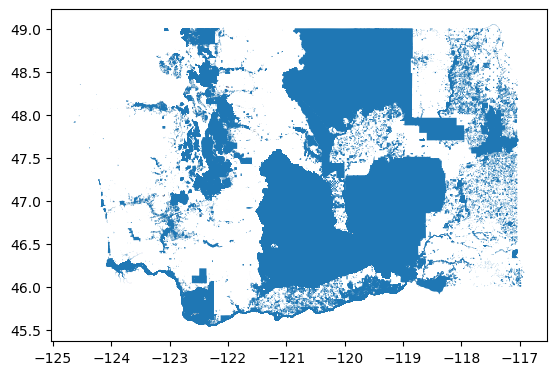

In [42]:
# plot shape info to map
gdfin1.plot()

In [43]:
# create output for Regulatory Area #1 dataframe
df = pd.DataFrame()

columnsList = ['in_SiteNativeID', 'geometry']
goutdf1 = pd.DataFrame(columns=columnsList, index=gdfin1.index)

goutdf1['in_SiteNativeID'] =  gdfin1["in_SiteNativeID"].astype(str)  #in_ReportingUnitNativeID needs to match source from above equivalent dataframe
goutdf1['geometry'] = gdfin1['in_Geometry']
goutdf1 = goutdf1.drop_duplicates().reset_index(drop=True)

# drop geometery from outdf
outdf = outdf.drop(['in_Geometry'], axis=1)


print(len(goutdf1))
goutdf1.head()

162426


,in_SiteNativeID,geometry
0,wadeID0,POLYGON ((-119.74932954399998 46.5844658030000...
1,wadeID1,POLYGON ((-119.74932954399998 46.5844658030000...
2,wadeID2,POLYGON ((-119.77580335899995 46.5845073900000...
3,wadeID3,POLYGON ((-119.77580335899995 46.5845073900000...
4,wadeID4,POLYGON ((-119.77067780999994 46.5770709530000...


## Export Outputs

In [44]:
outdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339303 entries, 0 to 339302
Data columns (total 62 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   WaDEUUID                                      339303 non-null  object        
 1   in_MethodUUID                                 339303 non-null  object        
 2   in_VariableSpecificUUID                       339303 non-null  object        
 3   in_OrganizationUUID                           339303 non-null  object        
 4   in_GNISFeatureNameCV                          339303 non-null  object        
 5   in_WaterQualityIndicatorCV                    339303 non-null  object        
 6   in_WaterSourceName                            339303 non-null  object        
 7   in_WaterSourceNativeID                        339303 non-null  object        
 8   in_WaterSourceTypeCV                          339303 n

In [45]:
outdf

,WaDEUUID,in_MethodUUID,in_VariableSpecificUUID,in_OrganizationUUID,in_GNISFeatureNameCV,in_WaterQualityIndicatorCV,in_WaterSourceName,in_WaterSourceNativeID,in_WaterSourceTypeCV,in_CoordinateAccuracy,in_CoordinateMethodCV,in_County,in_EPSGCodeCV,in_GNISCodeCV,in_HUC12,in_HUC8,in_Latitude,in_Longitude,in_NHDNetworkStatusCV,in_NHDProductCV,in_PODorPOUSite,in_SiteName,in_SiteNativeID,in_SitePoint,in_SiteTypeCV,in_StateCV,in_USGSSiteID,in_AllocationApplicationDate,in_AllocationAssociatedConsumptiveUseSiteIDs,in_AllocationAssociatedWithdrawalSiteIDs,in_AllocationBasisCV,in_AllocationChangeApplicationIndicator,in_AllocationCommunityWaterSupplySystem,in_AllocationCropDutyAmount,in_AllocationExpirationDate,in_AllocationFlow_CFS,in_AllocationLegalStatusCV,in_AllocationNativeID,in_AllocationOwner,in_AllocationPriorityDate,in_AllocationSDWISIdentifierCV,in_AllocationTimeframeEnd,in_AllocationTimeframeStart,in_AllocationTypeCV,in_AllocationVolume_AF,in_BeneficialUseCategory,in_CommunityWaterSupplySystem,in_CropTypeCV,in_CustomerTypeCV,in_DataPublicationDate,in_DataPublicationDOI,in_ExemptOfVolumeFlowPriority,in_GeneratedPowerCapacityMW,in_IrrigatedAcreage,in_IrrigationMethodCV,in_LegacyAllocationIDs,in_OwnerClassificationCV,in_PopulationServed,in_PowerType,in_PrimaryBeneficialUseCategory,in_SDWISIdentifierCV,in_WaterAllocationNativeURL
0,waD4,WAwr_M1,WAwr_V1,WAwr_O1,,,,wadeId1,Groundwater,field checked with GPS,,,4326,,,,46.43540,-120.20300,,,POD,,POD201191,,Well (or ground water device unknown),WA,,,,,,,,,,4.01000,Active,wa6463294,Fagerness Kari,2015-02-06,,,,ChangeROE,873.00000,Irrigation,,,,,,0,,429.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...
1,waD4,WAwr_M1,WAwr_V1,WAwr_O1,,,,wadeId1,Groundwater,field checked with GPS,,,4326,,,,46.43540,-120.20300,,,POD,,POD201191,,Well (or ground water device unknown),WA,,,,,,,,,,4.01000,Active,wa6463294,Wa Dnr *,2015-02-06,,,,ChangeROE,873.00000,Irrigation,,,,,,0,,429.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...
2,waD5,WAwr_M1,WAwr_V1,WAwr_O1,,,,wadeId1,Groundwater,proposed (does not exist in real world),,,4326,,,,46.39510,-119.96500,,,POD,,POD201247,,Well (or ground water device unknown),WA,,,,,,,,,,0.28000,Active,wa2283570,Sunny Acres Ranch Llc,1993-06-11,,,,ChangeApplication,65.00000,"Domestic multiple, Dairy",,,,,,0,,,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...
3,waD5,WAwr_M1,WAwr_V1,WAwr_O1,,,,wadeId1,Groundwater,proposed (does not exist in real world),,,4326,,,,46.39510,-119.96500,,,POD,,POD201247,,Well (or ground water device unknown),WA,,,,,,,,,,0.28000,Active,wa2283570,Jongeneel Arie,1993-06-11,,,,ChangeApplication,65.00000,"Domestic multiple, Dairy",,,,,,0,,,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...
4,waD5,WAwr_M1,WAwr_V1,WAwr_O1,,,,wadeId1,Groundwater,proposed (does not exist in real world),,,4326,,,,46.39510,-119.96500,,,POD,,POD201247,,Well (or ground water device unknown),WA,,,,,,,,,,0.28000,Active,wa2283570,Northwest Farm Credit Services Flca,1993-06-11,,,,ChangeApplication,65.00000,"Domestic multiple, Dairy",,,,,,0,,,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339298,waU163570,WAwr_M1,WAwr_V1,WAwr_O1,,,,wadeId1,Groundwater,,,,4326,,,,46.55984,-120.44317,,,POU,,wadeID163570,,,WA,,,,,,,,,,,Active,wa2046049,Brandt Cornelius D,NaT,,,,Claim,,Irrigation,,,,,,0,,100.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...
339299,waU163571,WAwr_M1,WAwr_V1,WAwr_O1,,,,wadeId1,Groundwater,,,,4326,,,,46.55766,-120.43958,,,POU,,wadeID163571,,,WA,,,,,,,,,,,Active,wa2041941,Brulotte Walter C,NaT,,,,Claim,,Irrigation,,,,,,0,,20.00000,,,,,,,,https://appswr.ecology.wa.gov/waterrighttracki...
339300,waU163572,WAwr_M1,WAwr_V1,WAwr_O1,,,,wadeId1,Groundwater,,,,4326,,,,46.560

In [46]:
# Export the output dataframe
outdf.to_csv('Pwr_Main.zip', compression=dict(method='zip', archive_name='Pwr_Main.csv'), index=False)  # The output, save as a zip
goutdf1.to_csv('P_Geometry.zip', compression=dict(method='zip', archive_name='P_Geometry.csv'), index=False)  # The output geometry.